In [1]:
import opendatasets as od
import pandas as pd
import numpy as np

# for cleaning memory usage
import gc

# for data visualization
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
dataset_url = 'https://www.kaggle.com/competitions/ashrae-energy-prediction/data'
od.download(dataset_url)

Skipping, found downloaded files in "./ashrae-energy-prediction" (use force=True to force download)


In [3]:
# Load the data
energy_data = pd.read_csv('ashrae-energy-prediction/train.csv')
weather_train = pd.read_csv('ashrae-energy-prediction/weather_train.csv')
building_metadata = pd.read_csv('ashrae-energy-prediction/building_metadata.csv')
test = pd.read_csv('ashrae-energy-prediction/test.csv')
weather_test = pd.read_csv('ashrae-energy-prediction/weather_test.csv')
print(energy_data.shape, weather_train.shape, building_metadata.shape, test.shape, weather_test.shape)


# Display the first few rows of the dataset
energy_data.head()


(20216100, 4) (139773, 9) (1449, 6) (41697600, 4) (277243, 9)


,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


**Observations**
- This is a supervised learning regression problem
- Training data is 2.5 GB in size
- Training data has 20 million rows
- Test set is much larger and has around 40 million rows.
- Training set has 4 columns 
  - `building_id`
  -  `meter`
  -  `timestamp`
  -  `meter_reading`
- Test set has all the columns except the target column `meter_reading`. 
- The submission file should contain `row_id` and `meter_reading` for each test sample.

On the test csv file, we have a column with the name "meter_reading" which is the target variable. But the test csv file we have is not the same as the train csv file. The test csv file has only the building_id, meter, timestamp and row_id columns. We need to predict the meter_reading for each row_id.

In [4]:
test.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


In [5]:
# types of Meter
energy_data['meter'].value_counts()


meter
0    12060910
1     4182440
2     2708713
3     1264037
Name: count, dtype: int64

**Observations**

The `train.csv` file contains the training dataset, which is the largest among the provided datasets. It includes the following columns:

- `building_id`: Foreign key linking to the `building_metadata.csv` file.
- `meter`: Categorical variable representing the type of energy meter:
  - `0`: Electricity
  - `1`: Chilled Water
  - `2`: Steam
  - `3`: Hot Water
- `timestamp`: Time of the recorded meter reading.
- `meter_reading`: Target variable representing energy consumption in kWh.

Our goal is to predict the `meter_reading` for electricity consumption (`meter = 0`). To achieve this, we will:

1. Filter the training (`energy_data`) and testing (`test`) datasets to include only rows where `meter = 0`.
2. Use the `building_id` column to merge the `energy_data` and `test` datasets with the `building_metadata.csv` file.
3. Incorporate weather data from `weather_train.csv` and `weather_test.csv` using the `site_id` and `timestamp` columns.

This approach will allow us to focus on electricity consumption while leveraging additional metadata and weather information to improve prediction accuracy.


In [6]:
# quero apenas os dados de eletricidade
energy_data = energy_data[energy_data['meter'] == 0]
energy_data = energy_data.drop(columns=['meter'])

test = test[test['meter'] == 0]
test = test.drop(columns=['meter'])

print(energy_data.shape, test.shape)

energy_data.head()

(12060910, 3) (24755760, 3)


,building_id,timestamp,meter_reading
0,0,2016-01-01 00:00:00,0.0
1,1,2016-01-01 00:00:00,0.0
2,2,2016-01-01 00:00:00,0.0
3,3,2016-01-01 00:00:00,0.0
4,4,2016-01-01 00:00:00,0.0


With the above approach, we reduced the training dataset size from **20,216,100** to **12,060,910**, representing a significant reduction. Similarly, the test dataset was reduced from **41,697,600** to **24,755,760**.


In [7]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


**Observations**

`weather_train.csv` and `weather_test.csv` contain the time series weather observations for different sites. 
- `site_id` - sites at which the obseravtions are recorded
- `air_temperature` - temperature measured in degree celsius. 
- `cloud_coverage` - portion of the sky covered in clouds
- `precip_depth_1hr` - amount of rain, snowfall, hail etc. recorded at the site in mm
- `sea_level_pressure` - average atmospheric pressure at mean sea level 
- `wind_direction` - direction that the wind comes from
- `wind_speed` - wind velocity



In [8]:
building_metadata.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


**Observations**

`building_metadata.csv` contains the building attributes for different sites. 
- `building_id` - foreign key for training data 
- `site_id` - sites at which the obseravtions are recorded. Foreign key for weather training and test dat 
- `primary_use` - categorical column indicating the primary usage fo the building  
- `square_feet` - gross area of the building
- `year_built` - Year in which the building was constructed.
- `floor_count` - number of floors in the building

---

Now, we will merge the building metadata dataset (`building_metadata`) and weather datasets (`weather_train` and `weather_test`) to enrich the available information and improve prediction quality.

Since the test dataset lacks the target variable (`meter_reading`), we will focus on the training dataset. We will split it into training and validation subsets to evaluate the model's performance. Afterward, we will use the trained model to make predictions on the test dataset, which will be significantly reduced to avoid memory issues.

In [9]:
# Merge the data
energy_data = energy_data.merge(building_metadata, on='building_id', how='left')
energy_data = energy_data.merge(weather_train, on=['site_id', 'timestamp'], how='left')
energy_data.head()

test = test.merge(building_metadata, on='building_id', how='left')
test = test.merge(weather_test, on=['site_id', 'timestamp'], how='left')

In [10]:
# Verificar se há valores nulos
energy_data.isnull().sum()


building_id                 0
timestamp                   0
meter_reading               0
site_id                     0
primary_use                 0
square_feet                 0
year_built            6470035
floor_count           9096083
air_temperature         47325
cloud_coverage        5329652
dew_temperature         49091
precip_depth_1_hr     2513679
sea_level_pressure    1018383
wind_direction         678715
wind_speed              66795
dtype: int64

As previously observed, there is a significant amount of missing values in the `year_built` and `floor_count` columns of the `building_metadata` dataset. Specifically:

- **`year_built`**: 6,470,035 missing values.
- **`floor_count`**: 9,096,083 missing values.

These columns are important for analysis as they provide information about the year of construction and the number of floors in the buildings. However, the absence of data in such a large proportion can negatively impact the model's quality if not handled properly.

To address these missing values, we decided to remove the rows corresponding to buildings with missing values in these columns. This approach significantly reduces the dataset size, but we believe the loss of information will not be too detrimental, considering the large volume of data available.

After removing buildings with missing data, the dataset size was reduced from **12 million rows** to **2 million rows**. Despite this significant reduction, the resulting dataset is still large enough to train robust machine learning models. Additionally, excluding buildings with missing data ensures that the model is trained with complete and reliable information, which can improve prediction accuracy.


In [ ]:
missing_buildings = building_metadata[
    building_metadata[["year_built", "floor_count"]].isna().any(axis=1)
]["building_id"].unique()

building_metadata = building_metadata[~building_metadata["building_id"].isin(missing_buildings)]

energy_data = energy_data[~energy_data["building_id"].isin(missing_buildings)]
test = test[~test["building_id"].isin(missing_buildings)]

# Verificar novos tamanhos dos datasets
print(f"Treino: {energy_data.shape}, Teste: {test.shape}, Metadata: {building_metadata.shape}")


Treino: (1957301, 15), Teste: (3994560, 15), Metadata: (231, 6)


In [12]:
energy_data.isnull().sum()

building_id                 0
timestamp                   0
meter_reading               0
site_id                     0
primary_use                 0
square_feet                 0
year_built                  0
floor_count                 0
air_temperature          5558
cloud_coverage        1266878
dew_temperature          5981
precip_depth_1_hr     1323547
sea_level_pressure     784114
wind_direction          40216
wind_speed               5606
dtype: int64

In [13]:
energy_data.head()

,building_id,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
105,107,2016-01-01 00:00:00,175.1840,1,Education,97532,2005.0,10.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1
106,108,2016-01-01 00:00:00,91.2653,1,Education,81580,1913.0,5.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1
107,109,2016-01-01 00:00:00,80.9300,1,Education,56995,1953.0,6.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1
108,110,2016-01-01 00:00:00,86.2283,1,Education,27814,2006.0,8.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1
109,111,2016-01-01 00:00:00,167.3920,1,Education,118338,1909.0,7.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1


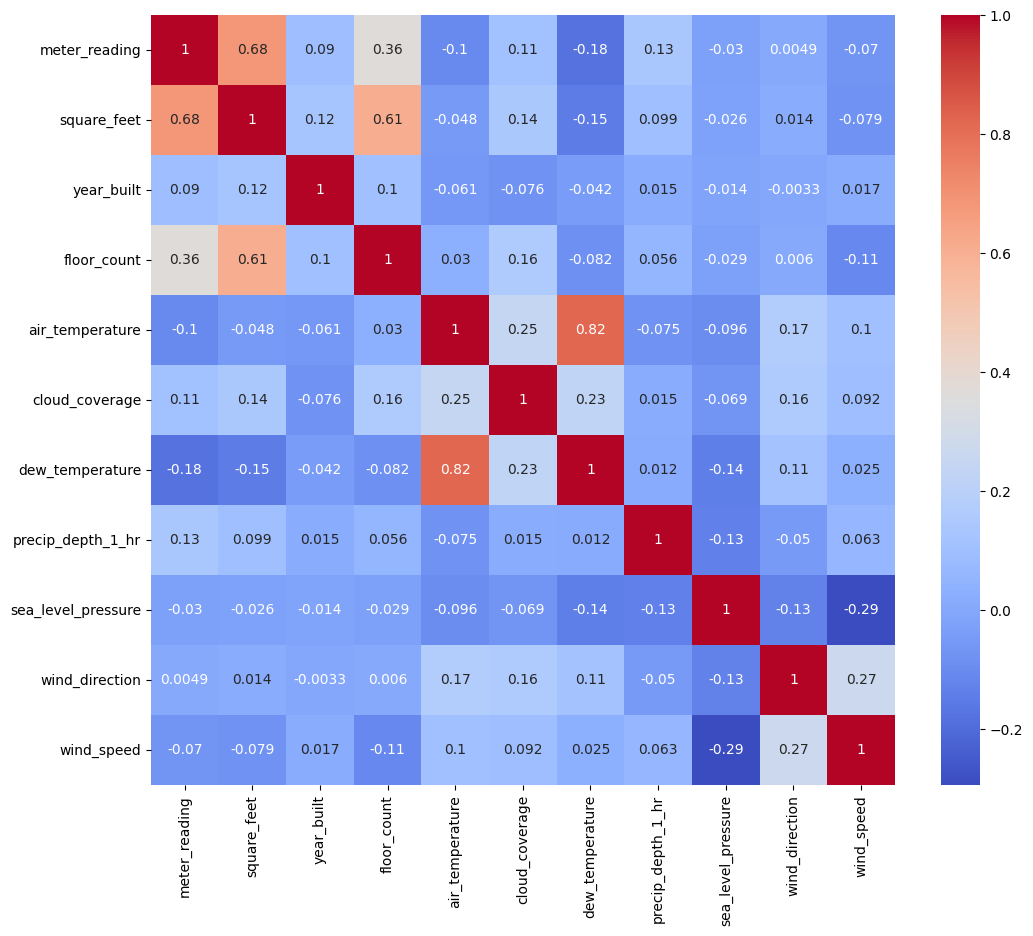

In [14]:
energy_data2 = energy_data.drop(columns=['timestamp', 'primary_use', 'site_id', 'building_id'])
corr = energy_data2.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()



| **Variable**            | **Meaning**                                      | **Relevance to Energy Consumption?** |
|-------------------------|--------------------------------------------------|---------------------------------------|
| `air_temperature`       | Air temperature at the location                  | High (affects heating/cooling)        | 
| `dew_temperature`       | Dew point temperature (humidity)                 | Moderate (related to humidity)        | 
| `cloud_coverage`        | Cloud coverage (0-10)                            | Low (affects solar illumination, but may have poor data) | 
| `precip_depth_1_hr`     | Precipitation amount (rain/snow) per hour         | Low (minimal impact on energy consumption) | 
| `sea_level_pressure`    | Atmospheric pressure at sea level                | Very low (almost irrelevant)          | 
| `wind_direction`        | Wind direction in degrees                        | Very low (minimal direct impact)      | 
| `wind_speed`            | Wind speed in m/s                                | Low (may affect natural ventilation)  | 


---

According to the correlation matrix, the following variables have such low correlation that they can be removed from the model:

- `wind_direction`
- `sea_level_pressure`
- `wind_speed`

The other variables do not have a correlation with the target variable `meter_reading` that is low enough to warrant removal at this stage. Therefore, no additional variables will be removed for now.



In [15]:
# vamos remover as colunas anteriormente faladas

energy_data = energy_data.drop(columns=['wind_direction', 'wind_speed', 'sea_level_pressure'])
test = test.drop(columns=['wind_direction', 'wind_speed', 'sea_level_pressure'])

energy_data.head()

,building_id,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr
105,107,2016-01-01 00:00:00,175.1840,1,Education,97532,2005.0,10.0,3.8,NaN,2.4,NaN
106,108,2016-01-01 00:00:00,91.2653,1,Education,81580,1913.0,5.0,3.8,NaN,2.4,NaN
107,109,2016-01-01 00:00:00,80.9300,1,Education,56995,1953.0,6.0,3.8,NaN,2.4,NaN
108,110,2016-01-01 00:00:00,86.2283,1,Education,27814,2006.0,8.0,3.8,NaN,2.4,NaN
109,111,2016-01-01 00:00:00,167.3920,1,Education,118338,1909.0,7.0,3.8,NaN,2.4,NaN


In [16]:
# ver se há valores nulos
energy_data.isnull().sum()

building_id                0
timestamp                  0
meter_reading              0
site_id                    0
primary_use                0
square_feet                0
year_built                 0
floor_count                0
air_temperature         5558
cloud_coverage       1266878
dew_temperature         5981
precip_depth_1_hr    1323547
dtype: int64

In [ ]:
weather_cols = ["air_temperature", "cloud_coverage", "dew_temperature", "precip_depth_1_hr"]

# Preencher valores ausentes com a mediana do próprio site_id
for col in weather_cols:
    energy_data[col] = energy_data.groupby("site_id")[col].transform(lambda x: x.fillna(x.median()))
    test[col] = test.groupby("site_id")[col].transform(lambda x: x.fillna(x.median()))


/opt/anaconda3/envs/meu_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/meu_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/meu_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/meu_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/meu_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/meu_env/lib/python3.10/site-packages/num

air_temperature            0
cloud_coverage         96000
dew_temperature            0
precip_depth_1_hr    1124350
dtype: int64
air_temperature            0
cloud_coverage        192720
dew_temperature            0
precip_depth_1_hr    2242560
dtype: int64


In [20]:
weather_cols = ["cloud_coverage", "precip_depth_1_hr"]
# mediana
for col in weather_cols:
    energy_data[col] = energy_data[col].fillna(energy_data[col].median())
    test[col] = test[col].fillna(test[col].median())

energy_data.isnull().sum()
test.isnull().sum()


row_id               0
building_id          0
timestamp            0
site_id              0
primary_use          0
square_feet          0
year_built           0
floor_count          0
air_temperature      0
cloud_coverage       0
dew_temperature      0
precip_depth_1_hr    0
dtype: int64

First, we filled the missing values in the following columns:
`weather_cols = ["air_temperature", "cloud_coverage", "dew_temperature", "precip_depth_1_hr"]`
using the median grouped by `site_id`.

Since not all missing values can be filled using the median grouped by `site_id`, we filled the remaining missing values with the global median.

In [21]:
# Verificar se há valores duplicados
energy_data.duplicated().sum()

np.int64(0)

In [22]:
# Resumo final
energy_data.head()

,building_id,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr
105,107,2016-01-01 00:00:00,175.1840,1,Education,97532,2005.0,10.0,3.8,0.0,2.4,0.0
106,108,2016-01-01 00:00:00,91.2653,1,Education,81580,1913.0,5.0,3.8,0.0,2.4,0.0
107,109,2016-01-01 00:00:00,80.9300,1,Education,56995,1953.0,6.0,3.8,0.0,2.4,0.0
108,110,2016-01-01 00:00:00,86.2283,1,Education,27814,2006.0,8.0,3.8,0.0,2.4,0.0
109,111,2016-01-01 00:00:00,167.3920,1,Education,118338,1909.0,7.0,3.8,0.0,2.4,0.0


In [23]:
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1957301 entries, 105 to 12060294
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   building_id        int64  
 1   timestamp          object 
 2   meter_reading      float64
 3   site_id            int64  
 4   primary_use        object 
 5   square_feet        int64  
 6   year_built         float64
 7   floor_count        float64
 8   air_temperature    float64
 9   cloud_coverage     float64
 10  dew_temperature    float64
 11  precip_depth_1_hr  float64
dtypes: float64(7), int64(3), object(2)
memory usage: 194.1+ MB


In [24]:
energy_data.describe()

,building_id,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr
count,1.957301e+06,1.957301e+06,1.957301e+06,1.957301e+06,1.957301e+06,1.957301e+06,1.957301e+06,1.957301e+06,1.957301e+06,1.957301e+06
mean,5.687847e+02,2.201678e+02,4.003534e+00,8.652092e+04,1.959186e+03,4.770461e+00,1.251391e+01,7.647311e-01,8.428959e+00,3.519520e-01
std,2.124044e+02,6.673284e+02,1.565868e+00,1.067194e+05,2.797384e+01,3.610044e+00,5.939424e+00,1.235234e+00,5.289156e+00,2.643633e+00
min,1.070000e+02,0.000000e+00,1.000000e+00,3.870000e+02,1.900000e+03,1.000000e+00,-2.880000e+01,0.000000e+00,-3.500000e+01,-1.000000e+00
25%,5.810000e+02,8.504600e+00,4.000000e+00,2.186600e+04,1.933000e+03,2.000000e+00,8.600000e+00,0.000000e+00,5.000000e+00,0.000000e+00
50%,6.410000e+02,4.105000e+01,4.000000e+00,5.323400e+04,1.966000e+03,4.000000e+00,1.330000e+01,0.000000e+00,9.400000e+00,0.000000e+00
75%,7.000000e+02,1.499250e+02,5.000000e+00,1.178140e+05,1.976000e+03,7.000000e+00,1.640000e+01,2.000000e+00,1.220000e+01,0.000000e+00
max,8.030000e+02,1.750210e+04,7.000000e+00,7.642370e+05,2.016000e+03,2.600000e+01,3.500000e+01,9.000000e+00,2.290000e+01,2.620000e+02


In [25]:
# Alterar o nome para target e colocar no final
energy_data = energy_data.rename(columns={'meter_reading': 'target'})
cols = energy_data.columns.tolist()
cols.remove('target')
cols.append('target')
energy_data = energy_data[cols]

energy_data.head()


,building_id,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,target
105,107,2016-01-01 00:00:00,1,Education,97532,2005.0,10.0,3.8,0.0,2.4,0.0,175.1840
106,108,2016-01-01 00:00:00,1,Education,81580,1913.0,5.0,3.8,0.0,2.4,0.0,91.2653
107,109,2016-01-01 00:00:00,1,Education,56995,1953.0,6.0,3.8,0.0,2.4,0.0,80.9300
108,110,2016-01-01 00:00:00,1,Education,27814,2006.0,8.0,3.8,0.0,2.4,0.0,86.2283
109,111,2016-01-01 00:00:00,1,Education,118338,1909.0,7.0,3.8,0.0,2.4,0.0,167.3920


In [ ]:
# shape
print(energy_data.shape, test.shape)

# salvar os dados
energy_data.to_csv('data/energy_data.csv', index=False)
# test.to_csv('data/test.csv', index=False) # Caso um dia queira usar o test

(1957301, 12) (3994560, 12)


### Summary of the Process and Conclusions

#### 1. **Data Loading and Preprocessing**
- Data was loaded from multiple CSV files, including `train.csv`, `test.csv`, `weather_train.csv`, `weather_test.csv`, and `building_metadata.csv`.
- Tables were merged using keys such as `building_id`, `site_id`, and `timestamp` to enrich the data with metadata and weather conditions.

#### 2. **Data Filtering**
- Focused only on electricity consumption (`meter = 0`), significantly reducing the size of the training and testing datasets.
- Removed columns with low relevance to energy consumption, such as `wind_direction`, `wind_speed`, and `sea_level_pressure`, based on correlation analysis.

#### 3. **Handling Missing Values**
- Filled missing values in weather variables (`air_temperature`, `cloud_coverage`, `dew_temperature`, `precip_depth_1_hr`) using the median grouped by `site_id`.
- Remaining missing values were filled with the global median to ensure no null values remained.

#### 4. **Removal of Incomplete Data**
- Identified that the `year_built` and `floor_count` columns had a large number of missing values. Decided to remove buildings with missing data in these columns.
- This decision reduced the training dataset size from **12 million** to **2 million** rows, ensuring higher data reliability.

#### 5. **Correlation Analysis**
- Generated a correlation matrix to identify variables with low relationships to energy consumption (`meter_reading`).
- Variables like `air_temperature` and `square_feet` showed high relevance, while others, such as `wind_direction`, were discarded.

#### 6. **Reorganization and Saving**
- Renamed the `meter_reading` column to `target` and moved it to the end of the dataset.
- Saved the processed datasets (`energy_data` and `test`) as CSV files for future use.
